In [4]:
# Install necessary libraries
import ftplib
from io import BytesIO
import pandas as pd
import datetime
import numpy as np
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns

In [ ]:
# Download CSV files from the Trackman FTP
def download_directory_to_memory(ftp, remote_directory, cutoff_date):
    result = {}
    ftp.cwd(remote_directory)
    
    file_list = ftp.nlst()

    for file_name in file_list:
        modified_time = ftp.sendcmd(f"MDTM {file_name}").split(" ")[1]
        modified_date = datetime.datetime.strptime(modified_time, "%Y%m%d%H%M%S").date()
        
        if modified_date > cutoff_date:
            print(f"Skipping {file_name} - Modified after cutoff date")
            continue

        if is_ftp_directory(ftp, file_name):
            result[file_name] = download_directory_to_memory(ftp, file_name, cutoff_date)
        else:
            memory_file = BytesIO()
            ftp.retrbinary(f"RETR {file_name}", memory_file.write)
            memory_file.seek(0)
            result[file_name] = memory_file
            print(f"Downloaded {file_name} to memory")

    ftp.cwd('..')
    return result

def is_ftp_directory(ftp, file_name):
    current = ftp.pwd()
    try:
        ftp.cwd(file_name)
        ftp.cwd(current)
        return True
    except ftplib.error_perm:
        return False
    
ftp_server = "ftp.Trackmanbaseball.com"
ftp_user = # Confidential
ftp_password = # Confidential
remote_directory = "/v3"

# If needed determine the cut off dat
cutoff_date = datetime.date(2024, 5, 18)

# Connect to the FTP server
ftp = ftplib.FTP(ftp_server)
ftp.login(user=ftp_user, passwd=ftp_password)
print(f"Connected to FTP server: {ftp_server}")

# Download the directory 
memory_directory = download_directory_to_memory(ftp, remote_directory, cutoff_date)
ftp.quit()
print("Connection closed.")

# Convert the memory directory to a DataFrame
def memory_directory_to_dataframe(memory_dir):
    df_list = []
    for file_name, file_content in memory_dir.items():
        if isinstance(file_content, BytesIO):
            content = file_content.getvalue().decode('utf-8')  # Assuming text content
            df = pd.read_csv(BytesIO(content))  # Assuming CSV format
            df_list.append(df)
        elif isinstance(file_content, dict):
            sub_df_list = memory_directory_to_dataframe(file_content)
            df_list.extend(sub_df_list)
    
    return pd.concat(df_list, ignore_index=True)

# Create DataFrame from memory directory
df = memory_directory_to_dataframe(memory_directory)

# Print the DataFrame shape and first few rows
print("DataFrame shape:", df.shape)
print(df.head())

In [7]:
df = pd.concat([df for df in dfs if df is not None], ignore_index=True)

In [21]:
# Sort data by desired year
df['Date'] = pd.to_datetime(df['Date'])

df_2024 = df[df['Date'].dt.year == 2024]

In [31]:
# Remove any duplicate rows
df_2024 = df_2024.drop_duplicates()

# Create a variable to count the number of strikeouts
strikeouts_df = df_2024[df_2024['KorBB'] == 'Strikeout']
strikeouts_per_pitcher = strikeouts_df.groupby(['GameID', 'Pitcher']).size().reset_index(name='PitcherStrikeouts')
strikeouts_per_team = strikeouts_df.groupby(['GameID', 'BatterTeam']).size().reset_index(name='TeamStrikeouts')
combined_df = pd.merge(strikeouts_per_pitcher, strikeouts_per_team, on='GameID')

# Prepare the target and predictor variables
X = combined_df[['TeamStrikeouts', 'PitcherStrikeouts']]
y = combined_df['PitcherStrikeouts']

# Run model
scaler_X = MinMaxScaler()
X_normalized = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler()
y = y.values.reshape(-1, 1)  
y_normalized = scaler_y.fit_transform(y).flatten()
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.2)

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}')
model.save('strikeout_model.h5')
joblib.dump(scaler_X, 'scaler_X.save')
joblib.dump(scaler_y, 'scaler_y.save')

/Users/seaniredell/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 436us/step - loss: 3.8642e-04 - val_loss: 4.2812e-07
Epoch 2/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 424us/step - loss: 4.6358e-07 - val_loss: 3.6910e-08
Epoch 3/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 412us/step - loss: 1.4254e-07 - val_loss: 1.4823e-08
Epoch 4/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 420us/step - loss: 9.9132e-08 - val_loss: 9.1658e-09
Epoch 5/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 414us/step - loss: 1.7152e-07 - val_loss: 8.5500e-08
Epoch 6/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 413us/step - loss: 1.0431e-07 - val_loss: 8.4936e-09
Epoch 7/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 417us/step - loss: 9.4031e-08 - val_loss: 8.3591e-09
Epoch 8/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 413us/step - loss: 1.6352e-07 - val_loss: 7.4640e-09
Epoch 9/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 415us/step - loss: 1.6284e-07 - val_loss: 3.1803e-07
Epoch 10/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 414us/step - loss: 1.3384e-07 - val_loss: 5.0386e-09
Epoch 11/

Test loss: 1.0682322387767229e-10


['scaler_y.save']

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
R-squared: 0.9999999814355239


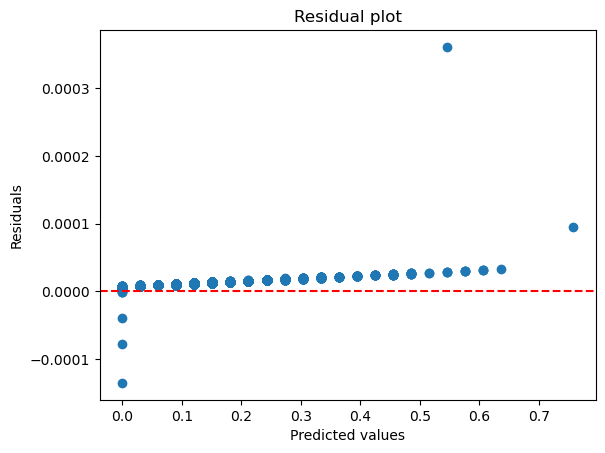

In [32]:
# Evaluate using R2
y_pred = model.predict(X_test).flatten()
r_squared = r2_score(y_test, y_pred)
print(f'R-squared: {r_squared}')

residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

Mean Squared Error (MSE): 1.0677447794013054e-10
Mean Absolute Error (MAE): 9.190989446573827e-06


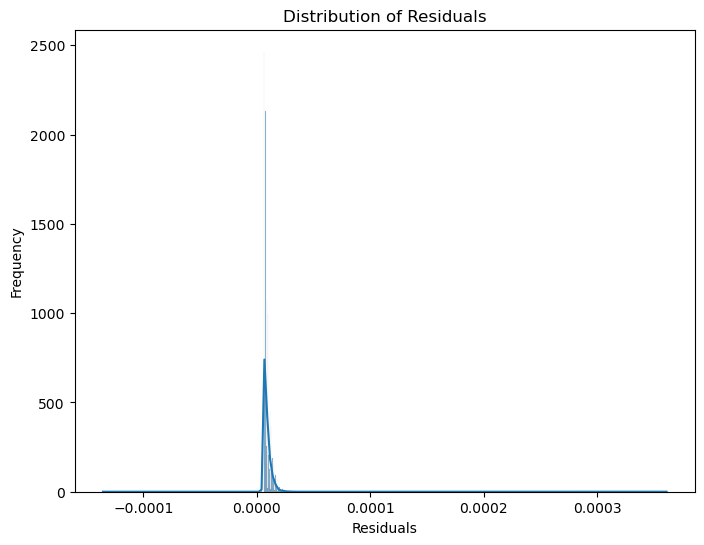

In [33]:
# Evaulate using Mean Squared Error (MSE) and Mean Absolute Error (MAE)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()